## Automatic Learning of Key Phrases and Topics in Document Collections

## Part 5: Topic Modeling Analysis

### Overview

This notebook is Part 5 of 5, in a series providing a step-by-step description of how to process and analyze the contents of a large collection of text documents in an unsupervsied manner. Using Python packages and custom code examples, we have implemented the basic framework that combines key phrase learning and latent topic modeling as described in the paper entitled ["Modeling Multiword Phrases with Constrained Phrases Tree for Improved Topic Modeling of Conversational Speech"](http://people.csail.mit.edu/hazen/publications/Hazen-SLT-2012.pdf) which was originally presented in the 2012 IEEE Workshop on Spoken Language Technology.

Although the paper examines the use of the technology for analyzing human-to-human conversations, the techniques are quite general and can be applied to a wide range natural language data including news stories, legal documents, research publications, social media forum discussion, customer feedback forms, product reviews, and many more.

Part 5 of the series shows how to analysis the topical content of a collection of text docuemnts and correlate topical information against other meta-data associated with the document collection. The topic model an topic summarizations were generated in Part 3 of the series.  


### Import Relevant Python Packages

Part 5 primarily relies on the [matplotlib Python library](http://matplotlib.org) for generating graphs.

In [1]:
import numpy as np
import pandas 
import re
import math
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim import corpora, models
from operator import itemgetter
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

### Load Text Data

In [2]:
# Load full TSV file including a column of text
docsFrame = pandas.read_csv("../Data/CongressionalDataAll_Jun_2017.tsv", sep='\t')

In [3]:
print(docsFrame[90:100])

               ID                                               Text  \
90   hconres91-93  Makes it the sense of the Congress that the Jo...   
91   hconres92-93  Makes it the sense of the Congress that: (1) t...   
92   hconres93-93  Makes it the sense of Congress that it shall b...   
93   hconres94-93  Expresses the sense of the Congress that the P...   
94   hconres95-93  States the recognition by the Congress of the ...   
95   hconres96-93  Expresses the sense of Congress that Operation...   
96   hconres97-93  Expresses the sense of Congress that the Presi...   
97   hconres98-93  Expresses the sense of Congress that the Holy ...   
98   hconres99-93  Makes it the sense of Congress that it shall b...   
99  hconres100-93  Expresses the disapproval of Congress of all p...   

          Date             SponsorName Type State  District       Party  \
90  1973-01-23       Anderson, John B.  rep    IL      16.0  Republican   
91  1973-01-23       Gaydos, Joseph M.  rep    PA      20

### Compute the Quarter Information for Each Document

A congressional session lasts 2 years. To summarize Congressional actions taken over the duration of a session, we break each two year session into its 8 annual quarters. We can then summarize actions over the duration of these 8 quarters for each session.

In [4]:
# Break out the session number as a unique column in the documents frame 
# also create a column for the session quarter where we break dates down 
# into one of eight annual quarters per session, i.e., four quarters for 
# each of the two years in the session

reType = re.compile(r"^([a-z]+)[0-9]+$")

quarterArray = [] 
sessionArray = []
typeArray = []
for i in range(0,len(docsFrame)):

    dateFields = (docsFrame['Date'][i]).split('-')
    year = int(dateFields[0])
    month = int(dateFields[1])
    evenYear = int ((year % 2) == 0) 
    quarterArray.append(int((month - 1) / 3 ) + (evenYear * 4))

    idFields = (docsFrame['ID'][i]).split('-')
    
    billType = reType.match(idFields[0]).group(1)
    typeArray.append(billType)
    session = int(idFields[1])
    sessionArray.append(session)

# Add the meta-data entries into the data frame
docsFrame['Quarter'] = quarterArray
docsFrame['Session'] = sessionArray
docsFrame['Type'] = typeArray

# Extract the minimum session number in the data
minSessionNum = min(sessionArray)  


In [5]:
sessionQuarterIndex = []
for i in range(len(docsFrame)):
    session = docsFrame['Session'][i]
    quarter = docsFrame['Quarter'][i]
    sessionQuarterIndex.append(((session-minSessionNum)*8)+quarter)
    
docsFrame['SessionQuarterIndex'] = sessionQuarterIndex
maxSessionQuarterIndex = max(sessionQuarterIndex)
print("Total number of quarters over all sessions in data:", maxSessionQuarterIndex+1)

Total number of quarters over all sessions in data: 178


In [6]:
print(docsFrame[90:100])

               ID                                               Text  \
90   hconres91-93  Makes it the sense of the Congress that the Jo...   
91   hconres92-93  Makes it the sense of the Congress that: (1) t...   
92   hconres93-93  Makes it the sense of Congress that it shall b...   
93   hconres94-93  Expresses the sense of the Congress that the P...   
94   hconres95-93  States the recognition by the Congress of the ...   
95   hconres96-93  Expresses the sense of Congress that Operation...   
96   hconres97-93  Expresses the sense of Congress that the Presi...   
97   hconres98-93  Expresses the sense of Congress that the Holy ...   
98   hconres99-93  Makes it the sense of Congress that it shall b...   
99  hconres100-93  Expresses the disapproval of Congress of all p...   

          Date             SponsorName     Type State  District       Party  \
90  1973-01-23       Anderson, John B.  hconres    IL      16.0  Republican   
91  1973-01-23       Gaydos, Joseph M.  hconres  

### Plot Count of Total Congressional Actions Taken per Session Quarter

This plot shows the total number of Congressional actions proposed by congress aggregated over each of the eight annual quarters in a Congressional session over all sessions from 1983 until 2016. Notice that the first quarter of a session after a new Congress starts, there is a large amount of activity. By the third annual quarter of the session, activity has subsided to a typical level. The final annual quarter in the second year of the session encompasses the election season and the two months of "lame duck" status for the Congress. During this time Congress typically does not enagage in new legislative activity.


[83832, 50102, 27895, 29292, 27932, 36068, 25235, 9073]


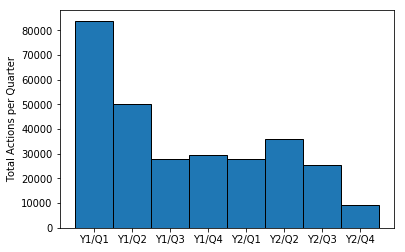

In [7]:
totalDocsPerQuarter = []

for i in range(8):
    totalDocsPerQuarter.append(len(docsFrame[docsFrame['Quarter'] == i]))
print(totalDocsPerQuarter) 

N = len(totalDocsPerQuarter)
xvalues = np.arange(N)
xlabels = ['Y1/Q1', 'Y1/Q2', 'Y1/Q3', 'Y1/Q4', 'Y2/Q1', 'Y2/Q2', 'Y2/Q3', 'Y2/Q4']
plt.bar(xvalues, totalDocsPerQuarter, width=1.0, edgecolor="black")
plt.ylabel('Total Actions per Quarter')
plt.xticks(xvalues, xlabels)
plt.show()

In [8]:
totalBillsPerQuarter = []
totalResolutionsPerQuarter = []
isBill = (docsFrame['Type'] == 'hr') | (docsFrame['Type'] == 's')
isResolution = (isBill==False)

for i in range(8):  
    totalBillsPerQuarter.append(len(docsFrame[ (docsFrame['Quarter'] == i) & isBill ])) 
    totalResolutionsPerQuarter.append(len(docsFrame[ (docsFrame['Quarter'] == i) & isResolution ]))
        
totalResolutionsPerQuarter 


[13829, 8281, 5427, 6267, 6419, 7396, 5926, 2572]

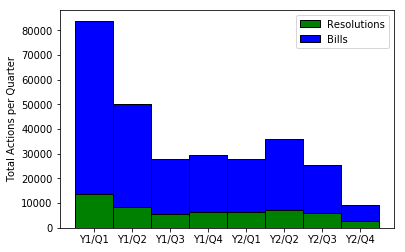

In [9]:
N = len(totalDocsPerQuarter)
xvalues = np.arange(N)
xlabels = ['Y1/Q1', 'Y1/Q2', 'Y1/Q3', 'Y1/Q4', 'Y2/Q1', 'Y2/Q2', 'Y2/Q3', 'Y2/Q4']
p1 = plt.bar(xvalues, totalResolutionsPerQuarter, color='g', edgecolor="black", width=1.0)
p2 = plt.bar(xvalues, totalBillsPerQuarter, width=1.0, color='b', edgecolor="black", bottom=totalResolutionsPerQuarter)
plt.ylabel('Total Actions per Quarter')
plt.xticks(xvalues, xlabels)
plt.legend((p1[0], p2[0]),('Resolutions', 'Bills'))
plt.show()

In [10]:
# Load the topic distributions for all documents from file
ldaDocTopicProbsFile = "../Data/CongressionalDocTopicProbs.npy"
docTopicProbs = np.load(ldaDocTopicProbsFile)
docTopicProbs.shape

(289429, 200)

In [11]:
type(isBill)

pandas.core.series.Series

In [12]:
# Aggregate the topic contributions for each document into topic bins for each quarter
numQuarters = maxSessionQuarterIndex + 1;
numTopics = docTopicProbs.shape[1]
numDocs = len(docsFrame)
topicActionTypeRawCounts = np.zeros((numTopics, 2))
for docIndex in range(numDocs):
    actionType = int(isBill[docIndex])
    for topicID in range(numTopics):
        topicActionTypeRawCounts[topicID, actionType] += docTopicProbs[docIndex, topicID]

In [13]:
print(docsFrame[60000:60010])
print(isBill[60000:60010])
sum(isBill)

              ID                                               Text  \
60000  hr7560-95  World War I Pension Act - Requires the Adminis...   
60001  hr7561-95  Amends Title II (Old-Age, Survivors, and Disab...   
60002  hr7562-95  Electric Utility Act Title I: Improving Effici...   
60003  hr7563-95  Permits postage-free mailing of correspondence...   
60004  hr7564-95  Public Safety Officers' Group Life Insurance A...   
60005  hr7565-95  Public Transportation Tax Incentive Act -- Ame...   
60006  hr7566-95  Emergency Highway Repair Act - Authorizes the ...   
60007  hr7567-95  Human Resources Development Act - Directs the ...   
60008  hr7568-95  Federal Correctional Ombudsman Act - Establish...   
60009  hr7569-95  Postal Service Reform Act - Requires all reven...   

             Date            SponsorName Type State  District       Party  \
60000  1977-06-02         Brinkley, Jack   hr    GA       3.0    Democrat   
60001  1977-06-02       Conte, Silvio O.   hr    MA       1.0  R

233312

### Plot Count of Total Congressional Actions Taken per Unique Quarter

This plot shows the total number of Congressional actions proposed by congress within each unique quarter over all sessions from 1983 until 2016. 




In [14]:
totalDocsPerUniqueQuarter = []
numQuarters = maxSessionQuarterIndex+1
for i in range(0,numQuarters):
    totalDocsPerUniqueQuarter.append(len(docsFrame[docsFrame['SessionQuarterIndex']==i]))
print(totalDocsPerUniqueQuarter) 

[9013, 3959, 2141, 2416, 2593, 2852, 2029, 1219, 8183, 4023, 2489, 2322, 2489, 2670, 2000, 109, 8350, 3468, 1938, 1628, 2311, 2664, 1509, 445, 4965, 2372, 1451, 1382, 1419, 1487, 1087, 427, 4409, 2011, 1041, 1261, 1426, 1447, 1177, 464, 4036, 2124, 1186, 1092, 1418, 1395, 691, 260, 3356, 2096, 1118, 1207, 1113, 1388, 1036, 288, 3555, 1931, 1042, 1014, 1110, 1279, 995, 352, 2964, 2249, 1224, 953, 1299, 1548, 1033, 517, 3105, 2182, 1159, 1296, 1318, 1512, 1135, 309, 2845, 1735, 1167, 974, 875, 1016, 890, 320, 2, 1, 0, 0, 0, 1, 0, 0, 2077, 1562, 920, 1009, 1050, 1167, 884, 472, 2497, 1870, 1161, 1065, 1155, 1422, 1000, 670, 2338, 1863, 1043, 1276, 819, 1891, 971, 588, 2749, 2142, 1071, 1049, 892, 1276, 949, 539, 2592, 2817, 1499, 1407, 976, 2185, 1315, 277, 3531, 2231, 1419, 2042, 1279, 1679, 1618, 239, 3138, 2424, 1237, 2272, 1228, 1466, 1481, 429, 2440, 2022, 1159, 1290, 1046, 3064, 934, 342, 2375, 2101, 1107, 1121, 1037, 1275, 1227, 393, 3021, 2322, 1323, 1216, 1079, 1384, 1274, 414, 2

In [15]:
# Create label set which marks only the first quarter of each year with the year label
sessionQuarterLabels = []
for i in range(0,numQuarters):
    if ( i % 4 ) == 0:
        year = int((i/4) + 1983)
        sessionQuarterLabels.append(str(year))
    else:
        sessionQuarterLabels.append("")
        
print (sessionQuarterLabels)        

['1983', '', '', '', '1984', '', '', '', '1985', '', '', '', '1986', '', '', '', '1987', '', '', '', '1988', '', '', '', '1989', '', '', '', '1990', '', '', '', '1991', '', '', '', '1992', '', '', '', '1993', '', '', '', '1994', '', '', '', '1995', '', '', '', '1996', '', '', '', '1997', '', '', '', '1998', '', '', '', '1999', '', '', '', '2000', '', '', '', '2001', '', '', '', '2002', '', '', '', '2003', '', '', '', '2004', '', '', '', '2005', '', '', '', '2006', '', '', '', '2007', '', '', '', '2008', '', '', '', '2009', '', '', '', '2010', '', '', '', '2011', '', '', '', '2012', '', '', '', '2013', '', '', '', '2014', '', '', '', '2015', '', '', '', '2016', '', '', '', '2017', '', '', '', '2018', '', '', '', '2019', '', '', '', '2020', '', '', '', '2021', '', '', '', '2022', '', '', '', '2023', '', '', '', '2024', '', '', '', '2025', '', '', '', '2026', '', '', '', '2027', '']


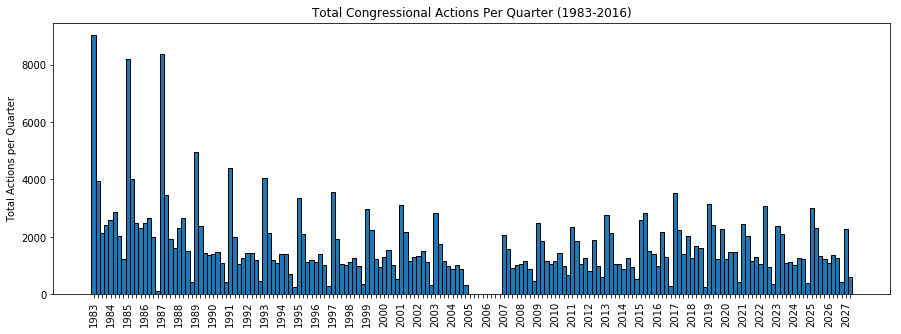

In [16]:
# Set the default figure size to be 15 in by 5 in
from pylab import rcParams
rcParams['figure.figsize'] = 15,5

# Create a function for plotting a topic over time
xlabels = sessionQuarterLabels
xvalues = np.arange(len(sessionQuarterLabels))
yvalues = totalDocsPerUniqueQuarter
    
plt.bar(xvalues, yvalues, width=1.0, edgecolor="black")
plt.title("Total Congressional Actions Per Quarter (1983-2016)")
plt.ylabel('Total Actions per Quarter')
plt.xticks(xvalues, xlabels, rotation=90)
plt.show()

### Plot Topics Over Time

Here we show how to aggregate the total amount of activity for any topic within each annual quarter over the entire span of the data from 1983 until 2016.

In [17]:
# Aggregate the topic contributions for each document into topic bins for each quarter
numQuarters = maxSessionQuarterIndex + 1;
numTopics = docTopicProbs.shape[1]
numDocs = len(docsFrame)
topicQuarterRawCounts = np.zeros((numTopics, numQuarters))
for docIndex in range(0,numDocs):
    quarter = docsFrame['SessionQuarterIndex'][docIndex]
    for topicID in range(0,numTopics):
        topicQuarterRawCounts[topicID, quarter] += docTopicProbs[docIndex, topicID]

In [18]:
# Get the topic summaries to use as titles for each topic plot
ldaTopicSummariesFile = "../Data/CongressionalDocTopicSummaries.tsv"
topicSummaries = pandas.read_csv(ldaTopicSummariesFile, sep='\t')

In [19]:
# Set the default figure size to be 15 in by 5 in
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

# Create a function for plotting a topic over time
def PlotTopic(topicID, topicQuarterRawCounts, ylabel, xlabels, topicSummaries):
    xvalues = np.arange(len(xlabels))
    yvalues = topicQuarterRawCounts[topicID]
    
    plt.bar(xvalues, yvalues, width=1.0, edgecolor="black")
    plt.title(topicSummaries['TopicSummary'][topicID])
    plt.ylabel(ylabel)
    plt.xticks(xvalues+0.50, xlabels, rotation=90)
    plt.show()

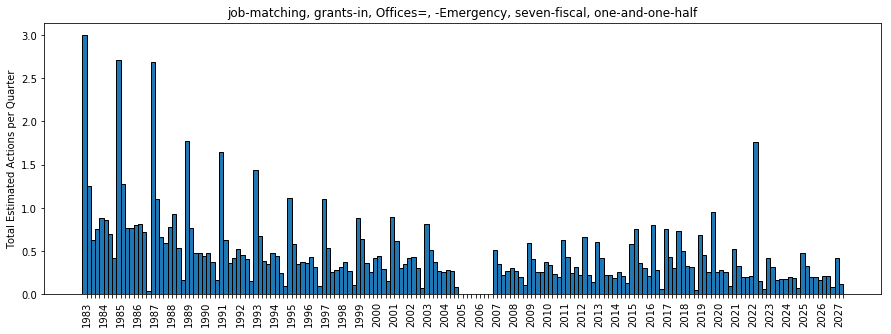

In [20]:
# Plot topic 101 (which was the top ranked topic identified in Part 4)
PlotTopic(101, topicQuarterRawCounts, 'Total Estimated Actions per Quarter', sessionQuarterLabels, topicSummaries)

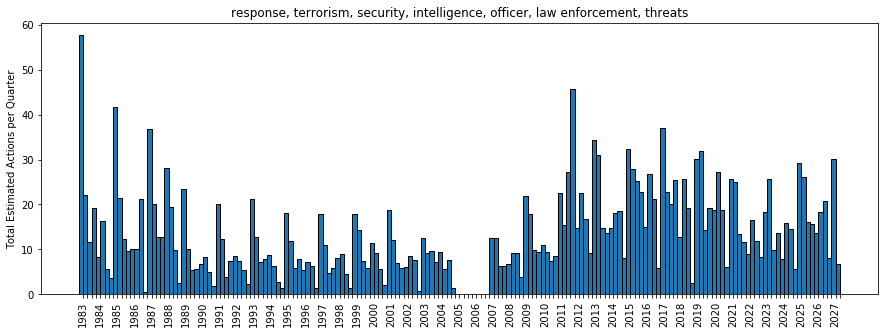

In [21]:
# Show a plot of topic 36 which was identified as the fifth highest ranked topic in Part 4.
PlotTopic(79, topicQuarterRawCounts, 'Total Estimated Actions per Quarter', sessionQuarterLabels, topicSummaries)

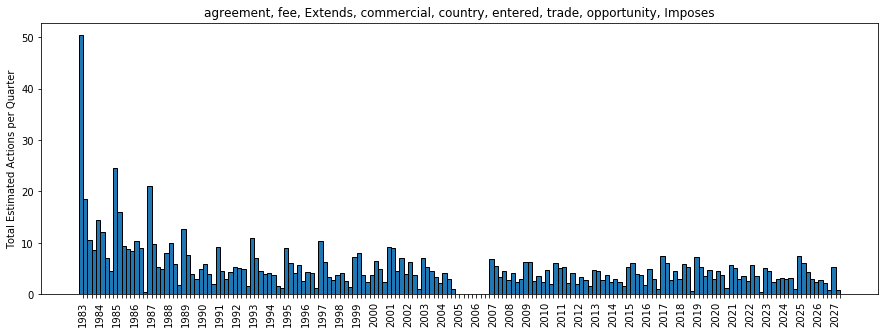

In [22]:
PlotTopic(37, topicQuarterRawCounts, 'Total Estimated Actions per Quarter', sessionQuarterLabels, topicSummaries)

### Normalized Topic Plots


In [23]:
np.seterr(divide='ignore', invalid='ignore')

# This array contain the probability that a randomly selected document 
# came from a specific quarter for the data time span (1973-2017) 
probQuarter = np.array(totalDocsPerUniqueQuarter, dtype='f') / sum(totalDocsPerUniqueQuarter)

# This array contains the prior probability of a topic across the whole corpus
probTopic = docTopicProbs.sum(axis=0)[:, np.newaxis]
probTopic = probTopic / np.sum(probTopic)

# Compute the conditional probability of a topic given a specific quarter  
normTopicGivenQuarter = (np.sum(topicQuarterRawCounts, axis=0))[:, np.newaxis]
probTopicGivenQuarter = np.transpose(np.transpose(topicQuarterRawCounts) / normTopicGivenQuarter)

# Compute the conditional probability of a specific quarter given a topic
probQuarterGivenTopic = topicQuarterRawCounts / (np.sum(topicQuarterRawCounts,axis=1)[:, np.newaxis])

# Produce a "heat" indicator to highlight quarters for which a topic has higher than expected activity
topicHeatMap = 10000 * probQuarterGivenTopic * probTopicGivenQuarter * np.log((probQuarterGivenTopic / probQuarter))


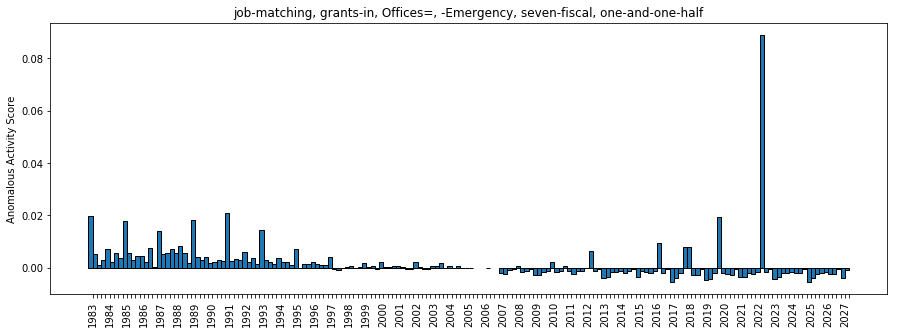

In [24]:
PlotTopic(101, topicHeatMap, 'Anomalous Activity Score', sessionQuarterLabels, topicSummaries)

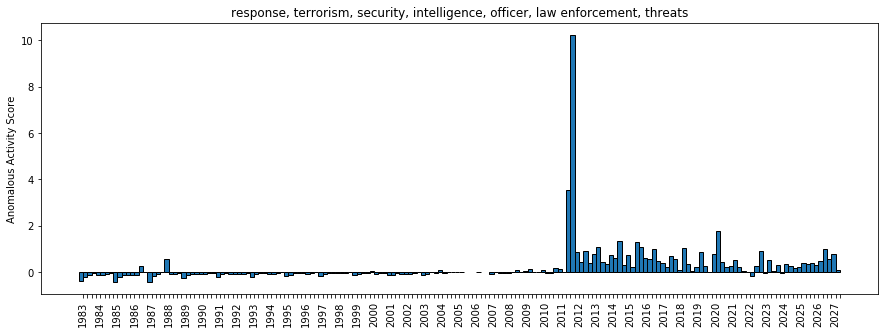

In [25]:
PlotTopic(79, topicHeatMap, 'Anomalous Activity Score', sessionQuarterLabels, topicSummaries)

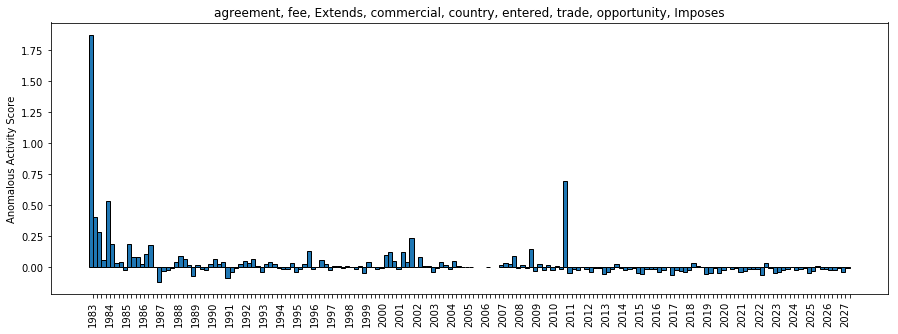

In [26]:
PlotTopic(37, topicHeatMap, 'Anomalous Activity Score', sessionQuarterLabels, topicSummaries)